In [1]:
#%matplotlib widget
from time import time
import random
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from functools import lru_cache
import numpy as np
from scipy import ndimage
from itertools import islice

In [2]:
# blur/focus based
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

def tile(im, nrows=1, ncolumns=6, debugging=False):
    M = im.shape[0] // nrows
    N = im.shape[1] // ncolumns
    rows = []
    for x in range(0, M*nrows,M):
        row = []
        for y in range(0,N*ncolumns,N):
            row.append(im[x:x+M,y:y+N])
        rows.append(row)
    if debugging:
        width = 3.0
        height = width/im.shape[1]*im.shape[0]
        fig = plt.figure(figsize = (width,height))
        gs = gridspec.GridSpec(nrows, ncolumns, figure=fig)
        gs.update(wspace=0.0, hspace=0.0)
        for r in range(nrows):
            for c in range(ncolumns):
                ax = fig.add_subplot(gs[r, c])
                ax.imshow(rows[r][c], vmin=0, vmax=im.max())
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

        plt.show()
            
    return rows

flatten = lambda l: [item for sublist in l for item in sublist]

def via_variance_of_laplacian(f):
    image = f['_']
    tiles = tile(image, nrows=3, ncolumns=1)
    return [variance_of_laplacian(i) for i in flatten(tiles)]

In [37]:
# Optical Flow Based
def fix_perspective(im, debugging=False):
    h, w = im.shape
    assert (w, h) == (640, 160) # this is tuned for a very specific crop and dashcam position
    left = 60 # left-right adjustment
    top = 5
    bottom = 30
    if debugging:
        src_rect = np.array([
            [245, originy+top],   [370, originy+top],
            [0, 125],   [600, 100]],
            dtype = "float32")
        dst_rect = np.array([
            [80-left, 0],    [330-left, 0],
            [108-left, 840],  [320-left, 800]],
            dtype = "float32")
        M = cv2.getPerspectiveTransform(src_rect, dst_rect)
        print(repr(M))
    else:
        M = np.array(
           [[-5.79976346e+00, -2.25571424e+01,  1.92672659e+03],
            [-1.81898940e-14, -1.56260338e+02,  3.90650844e+03],
            [ 5.42171076e-05, -1.56819369e-01,  1.00000000e+00]])
    dst = cv2.warpPerspective(im,M,(300,840-bottom))
    if debugging:
        plt.rcParams['figure.figsize'] = [20, 12]
        plt.imshow(im)
        plt.show()
        plt.imshow(dst)
        plt.show()
    return dst

def via_lk_optical_flow(frame):
    return optical_flow(frame['_'], frame['1'], frame)

def via_lk_optical_flow_multi(frame):
    xs = []
    for i in range(1,4):
        xs += optical_flow(frame['_'], frame[str(i)], frame)
    return xs

def optical_flow(image, image_next, frame, debugging=False):
    # params for ShiTomasi corner detection
    feature_params = dict(
        maxCorners = 100,
        qualityLevel = 0.007,
        minDistance = 20,
        blockSize = 9,
        #useHarrisDetector = True,
        )

    # Parameters for lucas kanade optical flow
    lk_params = dict(
        winSize  = (15,15),
        maxLevel = 1,
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
        )
    
    p0 = cv2.goodFeaturesToTrack(image, mask=None, **feature_params)
    p1, st, err = cv2.calcOpticalFlowPyrLK(image, image_next, p0, None, **lk_params)
    
    img = image_next.copy()

    df = pd.DataFrame()
    for i,(new,old) in enumerate(zip(p1[st==1],p0[st==1])):
        x1, y1 = old.ravel()
        x2, y2 = new.ravel()
        
        dx, dy = (x2-x1), (y2-y1)
        if dx == 0.0:
            dx = 0.00001 #prevent divide by zero
        Vf_slope = dy/dx
        Vf_mag = (dx**2 + dy**2)**0.5
        
        if Vf_mag < 2.5 or Vf_mag>165:
            # absurd
            continue

        df.loc[i,'|Vf|'] = Vf_mag
        df.loc[i,'Vf_slope'] = Vf_slope
        
        right_direction = y2>y1 and abs(Vf_slope) > 3 # down and steep
        df.loc[i,'right_direction'] = right_direction
        
        if right_direction:
            color=255
            df.loc[i,'good'] = True
        else:
            color=130
            df.loc[i,'good'] = False
        
        if debugging:
            img = cv2.arrowedLine(img,(int(x1),int(y1)),(int(x2),int(y2)), color, tipLength=.3)
            img = cv2.circle(img,(int(x1),int(y1)),2,color, -1)
    
    if len(df) != 0:
        # filter out noisy "small" flow vectors
        Vf_max = df[df['good']==True]['|Vf|'].max()
        df.loc[df['|Vf|']<Vf_max*.45,'good'] = False
    
    if debugging:
        if len(df) == 0:
            print("no useful points")
        else:
            display(df.sort_values(by='|Vf|'))       
            bins = list(range(0,101,10))
            plt.rcParams['figure.figsize'] = [20, 5]
            df['|Vf|'].hist(bins=bins)
            df[df['good']==True]['|Vf|'].hist(bins=bins)
            plt.show()

        plt.rcParams['figure.figsize'] = [20, 12]
        plt.imshow(img)
        plt.show()

    if len(df) == 0:
        return [np.nan, np.nan]
    else:
        return [
            df.loc[df['good'],'|Vf|'].mean(),
            df.loc[df['right_direction'],'|Vf|'].std(),
            #df.loc[df['right_direction'],'|Vf|'].count()/(0.000001+df.loc[df['right_direction']==False,'|Vf|'].count()),
            ]

In [38]:
# Diff based for stop detect
def via_diff(f):
    return [abs(cv2.subtract(f['_'],f['1']).sum())]


In [39]:
# Process frames
def frames(file='../data/train.mp4'):
    vidcap = cv2.VideoCapture(file)
    while True:
        success, image = vidcap.read()
        if success:
            yield {'orig': image, '_': image, 'xs':[]}
        else:
            return

originy=None
def crop(image, bottom=100, top=220):
    # take of top and bottom
    global originy
    originy = image.shape[0] / 2 - top
    return image[top:image.shape[0] - bottom,:]

def lookahead(frames, count=3):
    # add "lookahead" in keys '1', '2', ...
    # repeats at the end to keep length len
    fs = list()
    
    def _updated_f():
        f = fs.pop(0)
        f.update({str(n+1):f['_'] for n, f in enumerate(fs)})
        return f 
        
    for f in frames:
        fs.append(f)
        if len(fs) > count:
            yield _updated_f()

    for _ in range(count):
        fs.append(f)
        yield _updated_f()
        
def print_frame_keys(frames):
    for f in frames:
        print(repr(list(f.keys())))
        yield f

def view_frames(frames):
    for f in frames:
        for k in f.keys():
            if k == 'xs':
                continue
            cv2.imshow(k,f[k])
        try:
            cv2.waitKey(0)
        except KeyboardInterrupt:
            cv2.destroyAllWindows()
            print("Stopping early, KeyboardInterrupt")
            return
        yield f
    cv2.destroyAllWindows()

class FeatureExtractor():
    def __init__(self, frames_generator_maker):
        self._frames = frames_generator_maker
        self._steps = []
    def add_step(self, step):
        """step(frames_iterator) yields-> [frame,frame,...]; you can filter or gather frames"""
        if callable(step):
            self._steps.append(step)
    def add_processor(self, processor):
        """processor(img) returns-> img; frame['_'] is mutated"""
        def _step(frames):
            for f in frames:
                f['_'] = processor(f['_'])
                yield f
        self.add_step(_step)
    def add_analyzer(self, analyzer):
        """analyzer(frame) returns-> [x1,x2,...]; frame['_'] is forwarded untouched, features are collected"""
        def _step(frames):
            for f in frames:
                f['xs'] += analyzer(f)
                yield f
        self.add_step(_step)

    def __iter__(self):
        pipeline = self._frames()
        for s in self._steps:
            pipeline = s(pipeline)
        return pipeline
    def _pprogress(self, count, force=False):
        if force or time()-self._last>30:
            self._last = time()
            print(f"{count+1} processed in {(time()-self._start)/60:2.1f} minutes")
    def extract_features(self):
        self._start = time()
        self._last = self._start
        X = []
        i=0
        for i, f in enumerate(self):
            X.append(f['xs'])
            self._pprogress(i)
        self._pprogress(i,True)
        return X


In [42]:
fe = FeatureExtractor(frames)

#fe.add_step(lambda g: islice(g, 17500, 20400, 1)) # limit frames (start, stop, step)
#fe.add_step(lambda g: islice(g, 400, 420, 1)) # limit frames (start, stop, step)

fe.add_processor(lambda img: crop(img, bottom=100, top=220))
fe.add_processor(lambda img: cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
fe.add_processor(fix_perspective)
fe.add_processor(lambda img: cv2.GaussianBlur(img,(7,7),0))

fe.add_step(lambda frames: lookahead(frames, count=3))

#fe.add_analyzer(via_lk_optical_flow)
fe.add_analyzer(via_lk_optical_flow_multi)
fe.add_analyzer(via_variance_of_laplacian)
fe.add_analyzer(via_diff)

#fe.add_step(print_frame_keys)
#fe.add_step(view_frames)

xs = fe.extract_features()

322 processed in 0.5 minutes
672 processed in 1.0 minutes
1044 processed in 1.5 minutes
1357 processed in 2.0 minutes
1541 processed in 2.5 minutes
1738 processed in 3.0 minutes
2018 processed in 3.5 minutes
2381 processed in 4.0 minutes
2766 processed in 4.5 minutes
3151 processed in 5.0 minutes
3509 processed in 5.5 minutes
3869 processed in 6.0 minutes
4254 processed in 6.5 minutes
4631 processed in 7.0 minutes
4979 processed in 7.5 minutes
5296 processed in 8.0 minutes
5608 processed in 8.5 minutes
5922 processed in 9.0 minutes
6207 processed in 9.5 minutes
6485 processed in 10.0 minutes
6785 processed in 10.5 minutes
7086 processed in 11.0 minutes
7368 processed in 11.5 minutes
7663 processed in 12.0 minutes
7961 processed in 12.5 minutes
8261 processed in 13.0 minutes
8616 processed in 13.5 minutes
8849 processed in 14.0 minutes
9099 processed in 14.5 minutes
9296 processed in 15.0 minutes
9536 processed in 15.5 minutes
9778 processed in 16.0 minutes
10007 processed in 16.5 minut

In [43]:
def shuffle_time_in_chunks(df, n):
    """Break df into n-lengths mini dfs"""
    assert len(df) >= n*10, "doesn't meet minimum number of chunks"
    assert (len(df) % n) == 0, "all chunks equal size"
    
    chunk_count = len(df) // n
    chunks = []
    for x in range(0, len(df), n):
        chunks.append(df[x:x + n])
    random.shuffle(chunks)
    print(f"Using {len(chunks):0d} chunks")
    return pd.concat(chunks, axis=0)

In [210]:
y = pd.read_csv('../data/train.txt', header=None)
X = pd.DataFrame(xs)
X.describe()

,0,1,2,3,4,5,6,7,8,9
count,19792.000000,19540.000000,19943.000000,19770.000000,19997.000000,19807.000000,20400.000000,20400.000000,20400.000000,2.040000e+04
mean,30.285075,9.629279,53.858663,18.466074,73.476927,25.504214,2.429951,3.254773,3.384131,2.060806e+05
std,23.624369,8.006137,34.530283,13.205127,42.720587,16.704911,1.381638,2.112268,1.639592,1.543139e+05
min,2.501220,0.003616,2.501308,0.025064,2.501550,0.017739,0.348827,0.441444,0.421173,0.000000e+00
25%,12.843155,3.812138,24.146886,7.691720,35.398582,11.575699,1.495517,1.848284,2.115873,1.280638e+05
50%,25.500837,7.353302,48.148386,15.345098,71.462316,22.799784,2.148932,2.849210,3.103574,1.733775e+05
75%,41.841494,13.233636,82.293757,27.421618,112.958656,37.572920,3.003370,4.121873,4.284229,2.377012e+05
max,164.711704,107.644662,164.844868,112.136664,164.862450,107.069845,14.013617,19.977022,23.558937,3.287497e+06


In [244]:
X.fillna(value=0, inplace=True)
#X.fillna(method='pad', inplace=True)
X['024'] = (X[0] + X[2]/2 + X[4]/3)/3 # add "theoretical average"
X=X[[0,2,4,3,'024']] # 1,2,3 frame Vf and 2-frame std, and linear average of the three Vf
X.describe()

,0,2,4,3,024
count,20400.000000,20400.000000,20400.000000,20400.000000,20400.000000
mean,29.382461,52.652124,72.025397,17.895798,26.572330
std,23.832718,35.059355,43.514885,13.386412,16.630378
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.944194,22.963702,33.728363,7.043431,12.538373
50%,24.518810,46.426866,69.480943,14.678298,24.613411
75%,41.296766,81.654047,112.263412,27.016846,39.945543
max,164.711704,164.844868,164.862450,112.136664,96.540957


In [245]:
Xy = X.copy()
Xy['y'] = y

chunksize = 60
chunksize = 2040 # ten chunks
chunksize = 204*2 # 50
Xy = shuffle_time_in_chunks(Xy, chunksize)
Xy

Using 50 chunks


,0,2,4,3,024,y
2448,95.085656,84.601715,95.400397,31.543873,56.395549,24.541235
2449,49.877370,72.351971,127.648685,25.989012,42.867639,24.534295
2450,29.860497,78.529482,119.132072,29.247284,36.278643,24.545578
2451,54.720168,91.077281,126.858334,34.188900,47.514973,24.571187
2452,32.891597,100.468141,130.872595,47.021587,42.249955,24.573162
...,...,...,...,...,...,...
3667,45.321876,74.539648,119.052121,19.618708,40.758580,21.962908
3668,34.906039,83.421939,123.934818,12.336886,39.309538,21.979605
3669,48.912364,91.951821,125.968683,34.531337,45.625945,21.992005
3670,41.982151,70.671857,122.852963,16.637997,39.423022,22.009820


In [246]:
def find_testcount(test_df, fraction_testset=0.3):
    chunks = 1
    while True:
        chunks += 1
        testcount = chunksize * chunks
        if testcount/len(test_df)>fraction_testset:
            break
    print(f"using testcount = {testcount}")
    return testcount
    
testcount = find_testcount(Xy, .43)

Xy_train, Xy_test = train_test_split(Xy, test_size=testcount,shuffle=False)
Xy_train, Xy_test = Xy_train.copy(deep=True), Xy_test.copy(deep=True)
print("Percent test    =", testcount/len(Xy))

using testcount = 8976
Percent test    = 0.44


In [247]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor

m_dum = DummyRegressor(strategy='mean')

m_ensemble = StackingRegressor([
   ('svr', SVR(C=.3)),
   ('rf', RandomForestRegressor(n_estimators=60)),
   #('mlp', MLPRegressor(shuffle=False, alpha=0.1)),
   ])

pipe = Pipeline([
    ('scale', StandardScaler()),
    #('poly', PolynomialFeatures(interaction_only=False, include_bias=False)),
    #'reduce_dims', PCA(n_components=4)),
    #('svr', SVR(C=2)),
    #('rf', RandomForestRegressor()),
    #'mlp', MLPRegressor(shuffle=False, alpha=0.1)),
    #('br', BayesianRidge()),
    ('stack', m_ensemble),
    #('lin', LinearRegression()),
    ])

# # Training classifiers
# reg1 = GradientBoostingRegressor(random_state=1, n_estimators=10)
# reg2 = RandomForestRegressor(random_state=1, n_estimators=10)
# reg3 = LinearRegression()
# ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
# BaysianRidge
# MLP NN

from sklearn.model_selection import GridSearchCV
parameters = {
    'stack__svr__C':[.01, .1, .3, .9, 2, 4, 10, 15, 20, 50, 100, 600],
    'stack__rf__n_estimators': [20, 50, 100, 150],
    #'stack__rf__max_depth': None,
    
    #'svr__C':[10, 20, 30, 40, 70, 120],
    #'mlp__alpha':[0.0001, 0.001, 0.01],
    #'svr__C':[.3],RandomForestRegressor
    #'svr__gamma':[0.006/4, 0.006/2,0.006,0.006*2],
    }
grid = GridSearchCV(pipe, parameters, verbose=10, n_jobs=5, cv=5)

m_real = pipe


In [248]:
m_dum.fit(Xy_train[X.columns], Xy_train['y'])
m_real.fit(Xy_train[X.columns], Xy_train['y'])
try:
    print(m_real.best_estimator_)
except:
    print(m_real)

Pipeline(steps=[('scale', StandardScaler()),
                ('stack',
                 StackingRegressor(estimators=[('svr', SVR(C=0.3)),
                                               ('rf',
                                                RandomForestRegressor(n_estimators=60))]))])


In [249]:
# recreate full original df
Xy_test.loc[:,'is_test'] = True
Xy_train.loc[:,'is_test'] = False
Xy2 = pd.concat([Xy_test,Xy_train]).sort_index()

# get predictions
Xy2['dum'] = m_dum.predict(Xy2[X.columns])
Xy2['pred'] = m_real.predict(Xy2[X.columns])

# for convience
Xy2_test_ix = Xy2['is_test'] == True
Xy2_train_ix = Xy2['is_test'] == False

# smooth based on distribution of acceleration in training set
idea use kalman filter based 

In [250]:
# tune a kalman filter
from pykalman import KalmanFilter
em_vars = [
     #'transition_covariance',
     'observation_covariance',
     'initial_state_mean', 'initial_state_covariance']

T = np.array([[.0009]]) # smaller is more resistance to acceleration

kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1, transition_covariance=T)
kf_tuned = kf.em(Xy2.loc[Xy2_train_ix,'y'].values, n_iter=0, em_vars=em_vars)

In [251]:
# apply kalman
Xy2.loc[Xy2_test_ix,'pred_kf'] = kf_tuned.smooth(Xy2.loc[Xy2_test_ix,'pred'].values)[0]

In [252]:
# never below 0
Xy2.loc[Xy2['pred_kf']<0.0,'pred_kf'] = 0.0

0.45849128846870446

In [253]:
training_mean = Xy2.loc[Xy2_train_ix,'y'].mean()
training_mean = Xy2['y'].mean() # for full comparison, overly optimistic though
#scalefactor
training_mean/Xy2['024'].mean()

Xy2['0_kf_'] = kf_tuned.smooth(Xy2[0].values)[0]
Xy2['0_kf'] = Xy2['0_kf_'] * training_mean/Xy2['0_kf_'].mean()
Xy2['0_scaled'] = Xy2[0] * training_mean/Xy2[0].mean()

Xy2['024_kf_'] = kf_tuned.smooth(Xy2['024'].values)[0]
Xy2['024_kf'] = Xy2['024_kf_'] * training_mean/Xy2['024_kf_'].mean()
Xy2['024_scaled'] = Xy2['024'] * training_mean/Xy2['024'].mean()

Xy2['NoML'] = Xy2['024_kf'] # pick the best
Xy2['NoML_raw'] = Xy2['024_scaled'] # pick the best





Xy2['9_scaled'] = Xy2[9] * training_mean/Xy2[9].max()*2
Xy2['9_thresh'] = (Xy2[9]<1000)*10

KeyError: 9

Skipping 9_thresh


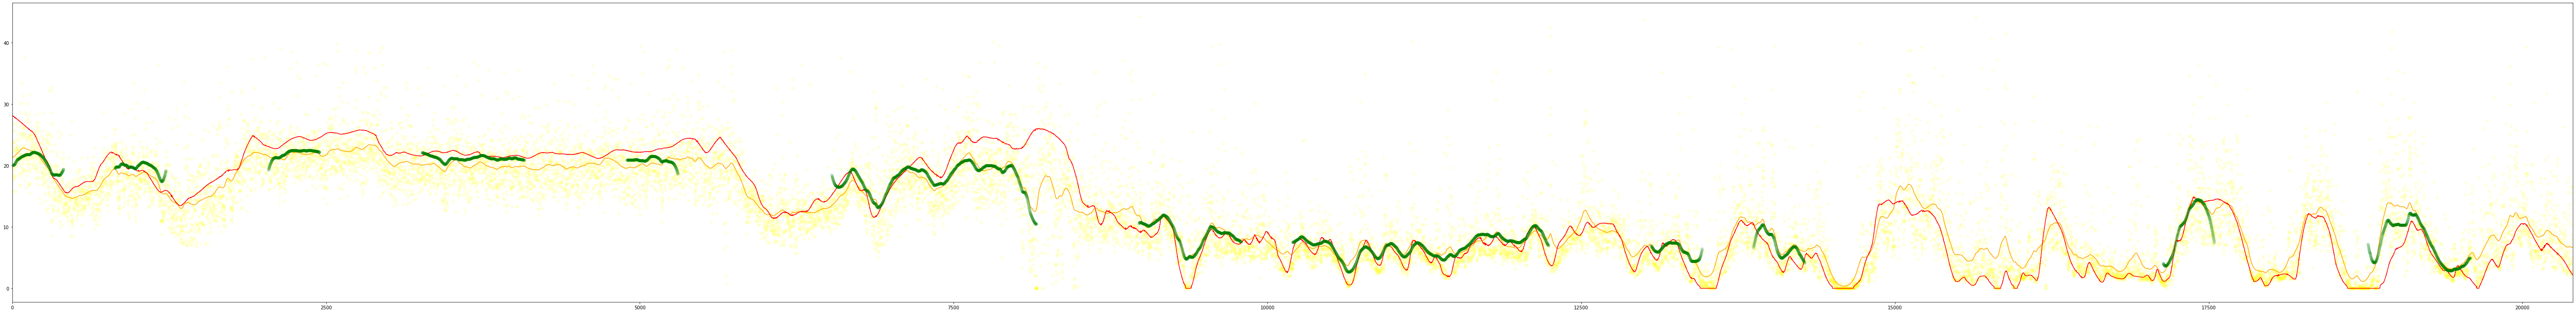

In [255]:
plt.rcParams['figure.figsize'] = [100, 12]
plt.gca().set_xlim((0,len(Xy2)))
def plot_Xy2(ix_mask, column, **kwargs):
    try:
        if ix_mask is None:
            df = Xy2.loc[:,column]
        else:
            df = Xy2.loc[ix_mask, column]
        plt.plot(df.index, df.values, **kwargs)
    except KeyError:
        print(f"Skipping {column}")
    
#plot_Xy2(Xy2_test_ix, 'pred', marker='o', linewidth=0.0, color='green', alpha=.1)

#plot_Xy2(Xy2_train_ix, 'pred', marker='o', linewidth=0.0, color='purple', alpha=.1)
plot_Xy2(None, 'NoML_raw', marker='o', linewidth=0.0, color='yellow', alpha=.1)
plot_Xy2(None, 'NoML', marker='', linewidth=1.5, color='orange')
plot_Xy2(None, '9_thresh', marker='', linewidth=0.5, color='blue')
plot_Xy2(None, 'y', marker='', linewidth=1.4, color='red')
plot_Xy2(Xy2_test_ix, 'pred_kf', marker='o', linewidth=0.0, color='green', alpha=.1)

In [256]:
def print_summary_line(ix_mask, column='dum'):
    if ix_mask is not None:
        Xy = Xy2[ix_mask]
    else:
        Xy = Xy2
    err = mean_squared_error(Xy['y'], Xy[column])
    print(f"{err:0.1f}", end='\t')

print(f"dummy\ttest\ttrain\ttest_kf\tNoML")
print_summary_line(Xy2_test_ix,'dum')
print_summary_line(Xy2_test_ix,'pred')
print_summary_line(Xy2_train_ix,'pred')
print_summary_line(Xy2_test_ix,'pred_kf')
print_summary_line(None,'NoML') # 10.3 was best, gaussian made it 7.2

dummy	test	train	test_kf	NoML
68.8	14.4	6.3	6.8	7.4	

dummy	test	train	test_kf	NoML
69.6	16.6	5.6	7.7	13.5	

^^^^got this,,,,,why>???????? trying to lower absurity ceiling again 260->160
maybe column multiplication should be done _after_ forward fillign/padding Xdf

In [ ]:
Xy2.describe()

In [ ]:
df = Xy2.copy()
df = df.groupby(np.arange(len(df.index)) // 100).mean()
df['loss']=abs(df['y']-df['NoML'])
#plt.plot(df.index, df.values)


In [ ]:
df.sort_values(by='loss', ascending=False).head(10).index.values

# inference

In [ ]:
# be sure pipeline is set up the same in both places
columns_used_to_train = X.columns

In [ ]:
feo = FeatureExtractor(lambda: frames(file='../data/train.mp4'))

#feo.add_step(lambda g: islice(g, 17500, 20400, 1)) # limit frames (start, stop, step)
#feo.add_step(lambda g: islice(g, 400, 420, 1)) # limit frames (start, stop, step)

feo.add_processor(lambda img: crop(img, bottom=100, top=220))
feo.add_processor(lambda img: cv2.cvtColor(img,cv2.COLOR_BGR2GRAY))
feo.add_processor(fix_perspective)
feo.add_processor(lambda img: cv2.GaussianBlur(img,(7,7),0))

feo.add_step(lambda frames: lookahead(frames, count=3))

#feo.add_analyzer(via_lk_optical_flow)
feo.add_analyzer(via_lk_optical_flow_multi)
feo.add_analyzer(via_variance_of_laplacian)
feo.add_analyzer(via_diff)

#feo.add_step(print_frame_keys)
#feo.add_step(view_frames)

xso = fe.extract_features()

In [ ]:
columns_used_to_train